TP ESPECIAL FUNDAMENTOS DE LA CIENCIA DE DATOS 2024 

DATASET: CALIDAD DE AGUA DEL RÍO DE LA PLATA - 2022

INTEGRANTES:
Abril Valentina Valentina Juarez, Matias Müller Gonzales y Julián Elias Rivero

In [37]:
!pip install matplotlib
!pip install fancyimpute
!pip install seaborn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fancyimpute import IterativeImputer,KNN
from sklearn.impute import KNNImputer

In [39]:
raw_dataset = pd.read_csv("Calidad_de_agua_2022.csv", sep =";")

Desplegamos el dataset para realizar un vistazo generico

In [40]:
raw_dataset

,orden,sitios,codigo,fecha,año,campaña,tem_agua,tem_aire,od,ph,...,dbo_mg_l,dqo_mg_l,turbiedad_ntu,hidr_deriv_petr_ug_l,cr_total_mg_l,cd_total_mg_l,clorofila_a_ug_l,microcistina_ug_l,ica,calidad_de_agua
0,1,Canal Villanueva y Río Luján,TI001,23/2/2022,2022,Verano,24.5,23.3,5.3,6.56,...,6.2,29,90,<0.10,<0.005,<0.001,<10,<0.20,55,Muy deteriorada
1,2,Río Lujan y Arroyo Caraguatá,TI006,23/2/2022,2022,Verano,25.4,23.3,2.25,6.56,...,5.8,29,34,<0.10,<0.005,<0.001,<10,<0.20,42,Extremadamente deteriorada
2,3,Canal Aliviador y Río Lujan,TI002,23/2/2022,2022,Verano,24.6,23.3,2.94,6.59,...,1.9,29,17,<0.10,<0.005,<0.001,<10,0.2,45,Muy deteriorada
3,4,Río Carapachay y Arroyo Gallo Fiambre,TI003,23/2/2022,2022,Verano,25.2,23.3,2.22,7.45,...,5.8,29,23,<0.10,<0.005,<0.001,<10,<0.20,46,Muy deteriorada
4,5,Río Reconquista y Río Lujan,TI004,23/2/2022,2022,Verano,24.1,20,1.02,6.39,...,2.6,59,18,<0.10,<0.005,<0.001,<10,<0.20,44,Extremadamente deteriorada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,38,Balneario Palo Blanco,BS092,31/10/2022,2022,Primavera,10,12,no se midió,no se midió,...,no se midió,<30,23,<0.10,<0.005,<0.001,2.1,<0.15,43,Extremadamente deteriorada
164,39,Diagonal 66 (descarga cloaca),BS095,31/10/2022,2022,Primavera,10,12,no se midió,no se midió,...,no se midió,31,18.2,<0.10,<0.005,<0.001,20.2,<0.15,37,Extremadamente deteriorada
165,40,Playa La Bagliardi,BS091,31/10/2022,2022,Primavera,10,12,no se midió,no se midió,...,no se midió,<30,40,<0.10,<0.005,<0.001,0.2,<0.15,49,Muy deteriorada
166,41,Balneario Municipal,BS094,31/10/2022,2022,Primavera,10,12,no se midió,no se midió,...,no se midió,39,90,<0.10,5,<0.001,10.5,<0.15,39,Extremadamente deteriorada


Ahora le pedimos un poco de informacion para analizar contexto de los datos

In [41]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   orden                    168 non-null    int64 
 1   sitios                   168 non-null    object
 2   codigo                   168 non-null    object
 3   fecha                    168 non-null    object
 4   año                      168 non-null    object
 5   campaña                  168 non-null    object
 6   tem_agua                 168 non-null    object
 7   tem_aire                 166 non-null    object
 8   od                       168 non-null    object
 9   ph                       168 non-null    object
 10  olores                   168 non-null    object
 11  color                    168 non-null    object
 12  espumas                  168 non-null    object
 13  mat_susp                 168 non-null    object
 14  colif_fecales_ufc_100ml  167 non-null    o

En total tenemos 31 columnas (atributos) y 168 filas (observaciones). Se puede ver que hay ciertas columnas con NULL y que el tipo de datos practicamente es OBJECT exceptuando la primer columna "orden" que es de tipo INT64.

In [42]:
raw_dataset.head()

,orden,sitios,codigo,fecha,año,campaña,tem_agua,tem_aire,od,ph,...,dbo_mg_l,dqo_mg_l,turbiedad_ntu,hidr_deriv_petr_ug_l,cr_total_mg_l,cd_total_mg_l,clorofila_a_ug_l,microcistina_ug_l,ica,calidad_de_agua
0,1,Canal Villanueva y Río Luján,TI001,23/2/2022,2022,Verano,24.5,23.3,5.3,6.56,...,6.2,29,90,<0.10,<0.005,<0.001,<10,<0.20,55,Muy deteriorada
1,2,Río Lujan y Arroyo Caraguatá,TI006,23/2/2022,2022,Verano,25.4,23.3,2.25,6.56,...,5.8,29,34,<0.10,<0.005,<0.001,<10,<0.20,42,Extremadamente deteriorada
2,3,Canal Aliviador y Río Lujan,TI002,23/2/2022,2022,Verano,24.6,23.3,2.94,6.59,...,1.9,29,17,<0.10,<0.005,<0.001,<10,0.2,45,Muy deteriorada
3,4,Río Carapachay y Arroyo Gallo Fiambre,TI003,23/2/2022,2022,Verano,25.2,23.3,2.22,7.45,...,5.8,29,23,<0.10,<0.005,<0.001,<10,<0.20,46,Muy deteriorada
4,5,Río Reconquista y Río Lujan,TI004,23/2/2022,2022,Verano,24.1,20,1.02,6.39,...,2.6,59,18,<0.10,<0.005,<0.001,<10,<0.20,44,Extremadamente deteriorada


A simple vista veo que tendremos que tratar lo siguiente:
1) Hay valores que enves de tener un tipo de dato cuantitativo en el atributo, tienen un string categorico que dice "no se midio" o variantes del mismo, por ejemplo en OD(oxigeno disuelto), esto deberia de ser reemplazado NA.
2) Hay datos cuantitativos que adelante del valor numerico tienen un string "<", como en el caso de las mediciones de los contaminantes en el agua.
Podriamos generar un mapa que descriva las observaciones de dicha variable. 
3) Hay datos cualitativos nominales que indican "presencia" o "ausencia" de algún compuesto en el agua, estás variables son dicotomicas, seran reemplazados por {0, 1} de acuerdo a su impacto en la muestra. 
4) Hay datos cualitativos ordinales como "muy deteriorada" o "extremadamente deteriorada" que hacen referencia al agua de esa zona, seran reemplazados mediante transformacion "ordinal encoding" ya que el orden es significativo.

Veamos cuantos valores repetidos tiene el dataset

In [43]:
raw_dataset.duplicated().sum()

np.int64(0)

Por lo visto no existe valores repetidos a simple vista.

Ya que empezaremos a modificar el dataset, una buena practica es copiar el dataset

In [44]:
copy_dataset = raw_dataset.copy()

podemos eliminar columnas que no tienen mucho sentido, como por ejemplo "orden" y vamos a eliminar "año", ya que todas las observaciones se hicieron en 2022 y no agregan mucha informacion

In [45]:
copy_dataset = copy_dataset.drop("orden",axis=1)
copy_dataset = copy_dataset.drop("año",axis=1)

Ahora vamos a ver que columnas tienen nulos

In [46]:
copy_dataset.isna().sum()

sitios                      0
codigo                      0
fecha                       0
campaña                     0
tem_agua                    0
tem_aire                    2
od                          0
ph                          0
olores                      0
color                       0
espumas                     0
mat_susp                    0
colif_fecales_ufc_100ml     1
escher_coli_ufc_100ml       1
enteroc_ufc_100ml           1
nitrato_mg_l                0
nh4_mg_l                    0
p_total_l_mg_l              0
fosf_ortofos_mg_l           0
dbo_mg_l                    1
dqo_mg_l                    0
turbiedad_ntu               0
hidr_deriv_petr_ug_l        0
cr_total_mg_l               0
cd_total_mg_l               0
clorofila_a_ug_l            1
microcistina_ug_l           0
ica                        13
calidad_de_agua            14
dtype: int64

Pareciera que existen muy pocos nulos, pero vamos a ver que sucede con el "no se midió" , asi que vamos a mostrar algunos ejemplos

In [47]:
copy_dataset[copy_dataset["dbo_mg_l"] == "no se midió"].head()

,sitios,codigo,fecha,campaña,tem_agua,tem_aire,od,ph,olores,color,...,dbo_mg_l,dqo_mg_l,turbiedad_ntu,hidr_deriv_petr_ug_l,cr_total_mg_l,cd_total_mg_l,clorofila_a_ug_l,microcistina_ug_l,ica,calidad_de_agua
10,Espigón La Farola,SI021,23/2/2022,Verano,no se midió,no se midió,no se midió,no se midió,no se midió,no se midió,...,no se midió,no se midió,no se midió,no se midió,no se midió,no se midió,no se midió,no se midió,NaN,NaN
12,Playa Espigón de Pacheco,SI024,23/2/2022,Verano,26.5,27,5.3,7.49,Ausencia,Ausencia,...,no se midió,no se midió,no se midió,no se midió,no se midió,no se midió,no se midió,no se midió,NaN,NaN
17,Parque de los Niños,CA041,23/2/2022,Verano,26.1,no se midió,4.8,7.4,Ausencia,Ausencia,...,no se midió,29,22,no se midió,<0.005,<0.002,no se midió,no se midió,54,Muy deteriorada
27,Náutico 400 m,QU062,23/2/2022,Verano,24,23,9.59,7.94,Ausencia,Ausencia,...,no se midió,29,26,<0.10,<0.005,<0.001,28,1,48,Muy deteriorada
30,Puerto Trinidad calle 47,BZ077,23/2/2022,Verano,no se midió,no se midió,no se midió,no se midió,no se midió,no se midió,...,no se midió,no se midió,no se midió,no se midió,no se midió,no se midió,no se midió,no se midió,NaN,NaN


Como pudimos ver hay muchisimos "no se midió" que representa NA, entonces vamos a convertir para todas las columnas
el "no se midió" y las distintas variantes a NA

In [48]:
lista_columnas = copy_dataset.columns

for col in lista_columnas:
    copy_dataset[col] = copy_dataset[col].replace(['no midieron este día', 'no se midió', 'no se determinó','No se midió',
                                                   'no midio la sonda','NA'], pd.NA)

Una vez pasado todos los valores a NA vamos a contar cuantos NA tenemos por cada variable

In [49]:
copy_dataset.isna().sum()

sitios                      0
codigo                      0
fecha                       5
campaña                     5
tem_agua                   23
tem_aire                   24
od                         36
ph                         28
olores                     13
color                      13
espumas                    13
mat_susp                   13
colif_fecales_ufc_100ml    15
escher_coli_ufc_100ml      15
enteroc_ufc_100ml          15
nitrato_mg_l               14
nh4_mg_l                   14
p_total_l_mg_l             21
fosf_ortofos_mg_l          14
dbo_mg_l                   58
dqo_mg_l                   14
turbiedad_ntu              14
hidr_deriv_petr_ug_l       18
cr_total_mg_l              17
cd_total_mg_l              17
clorofila_a_ug_l           18
microcistina_ug_l          18
ica                        14
calidad_de_agua            14
dtype: int64

In [50]:
copy_dataset.isna().sum() / copy_dataset.shape[0]

sitios                     0.000000
codigo                     0.000000
fecha                      0.029762
campaña                    0.029762
tem_agua                   0.136905
tem_aire                   0.142857
od                         0.214286
ph                         0.166667
olores                     0.077381
color                      0.077381
espumas                    0.077381
mat_susp                   0.077381
colif_fecales_ufc_100ml    0.089286
escher_coli_ufc_100ml      0.089286
enteroc_ufc_100ml          0.089286
nitrato_mg_l               0.083333
nh4_mg_l                   0.083333
p_total_l_mg_l             0.125000
fosf_ortofos_mg_l          0.083333
dbo_mg_l                   0.345238
dqo_mg_l                   0.083333
turbiedad_ntu              0.083333
hidr_deriv_petr_ug_l       0.107143
cr_total_mg_l              0.101190
cd_total_mg_l              0.101190
clorofila_a_ug_l           0.107143
microcistina_ug_l          0.107143
ica                        0

Además vemos que ninguna variable tiene más del 50% de valores faltantes, por ende no eliminaremos ninguna variable 

Se eliminaran todas aquellas observaciones que contengan 14 o mas atributos con valores NA, ya que no nos aportara mucha informacion

In [51]:
copy_dataset = copy_dataset.dropna(thresh=14)

A continuacion estamos mostrando aquellas observaciones donde en la columna microcistina_ug_l se encuentran valores que deberian ser numericos, pero son de tipo object, porque hay texto combinado con numeros. Observamos que hay esto sucede en reiteradas ocasiones.

In [52]:
copy_dataset[copy_dataset["microcistina_ug_l"] == " <0.15"].value_counts()

sitios                                 codigo  fecha      campaña   tem_agua  tem_aire  od     ph    olores     color      espumas   mat_susp   colif_fecales_ufc_100ml  escher_coli_ufc_100ml  enteroc_ufc_100ml  nitrato_mg_l  nh4_mg_l  p_total_l_mg_l  fosf_ortofos_mg_l  dbo_mg_l  dqo_mg_l  turbiedad_ntu  hidr_deriv_petr_ug_l  cr_total_mg_l  cd_total_mg_l  clorofila_a_ug_l  microcistina_ug_l  ica  calidad_de_agua           
Arroyo Abra Vieja y Santa Rosa         TI009   23/8/2022  invierno  15.6      15        8.68   7.13  Ausencia   Ausencia   Ausencia  Ausencia   3200                     2                      250                2.4           0.11      0.12            0.12               <2.0      <30       33              <0.10                <0.005         <0.001         200                <0.15             51   Muy deteriorada               1
Arroyo El Gato                         EN083   23/8/2022  invierno  12.8      9         2.49   8.01  Ausencia   Ausencia   Ausencia  Ausencia  

Para las siguientes columnas fue necesario quitar el string "<" y " <"(este caracter es el denominado NBSP)

In [53]:
columnas = [
    "nh4_mg_l",
    "p_total_l_mg_l",
    "fosf_ortofos_mg_l",
    "dbo_mg_l",
    "dqo_mg_l",
    "turbiedad_ntu",
    "hidr_deriv_petr_ug_l",
    "cr_total_mg_l",
    "cd_total_mg_l",
    "clorofila_a_ug_l",
    "microcistina_ug_l"
]
for col in columnas:
    copy_dataset[col] = copy_dataset[col].str.strip("<")
    copy_dataset[col] = copy_dataset[col].str.strip(" <")

Ahora veamos la variable "cd_total_mg_l" y notaremos que a pesar de quitar el "<" el tipo de dato no cambio, sigue siendo de tipo object

In [54]:
copy_dataset[copy_dataset["cd_total_mg_l"] == "0.001"].value_counts()

sitios                          codigo  fecha      campaña   tem_agua  tem_aire  od    ph    olores     color     espumas   mat_susp   colif_fecales_ufc_100ml  escher_coli_ufc_100ml  enteroc_ufc_100ml  nitrato_mg_l  nh4_mg_l  p_total_l_mg_l  fosf_ortofos_mg_l  dbo_mg_l  dqo_mg_l  turbiedad_ntu  hidr_deriv_petr_ug_l  cr_total_mg_l  cd_total_mg_l  clorofila_a_ug_l  microcistina_ug_l  ica  calidad_de_agua           
Arroyo Abra Vieja y Santa Rosa  TI009   23/2/2022  Verano    23.4      21        4.49  6.76  Ausencia   Ausencia  Ausencia  Ausencia   400                      100                    220                1.9           0.1       0.21            0.19               1.9       29        39             0.10                  0.005          0.001          10                0.20               58   Muy deteriorada               1
                                        23/8/2022  invierno  15.6      15        8.68  7.13  Ausencia   Ausencia  Ausencia  Ausencia   3200                     2

Entonces para esta variable en particular vamos a realizar un mapeo para sustituir el tipo string a tipo entero

In [55]:
mgl_map = {
    "0.001":0.001,
    "0.002":0.002
}
copy_dataset["cd_total_mg_l"] = copy_dataset["cd_total_mg_l"].map(mgl_map)
copy_dataset["cd_total_mg_l"].info()

<class 'pandas.core.series.Series'>
Index: 154 entries, 0 to 167
Series name: cd_total_mg_l
Non-Null Count  Dtype  
--------------  -----  
151 non-null    float64
dtypes: float64(1)
memory usage: 2.4 KB


Para la variable calidad_de_agua hicimos una transformacion ordinal encoding, donde cada valor unico de una caracteristica se mapea a un entero, tratando de ser lo mas cuidadoso para preservar el orden natural

In [56]:
niveles_deterioro = {
    "Deteriorada" : 1,
    "Muy deteriorada" : 2,
    "Extremadamente deteriorada" : 3
}

copy_dataset["calidad_de_agua"] = copy_dataset["calidad_de_agua"].map(niveles_deterioro)

Para las siguientes variables continuaremos con un tipo de mapeo dicotomico

In [57]:
mapeo_dicotomico = {
    "Ausencia" : 0,
    "Ausente" : 0,
    "ausencia" : 0,
    "presencia" : 1,
    "Presencia" : 1
}

copy_dataset["olores"] = copy_dataset["olores"].map(mapeo_dicotomico)
copy_dataset["color"] = copy_dataset["color"].map(mapeo_dicotomico)
copy_dataset["espumas"] = copy_dataset["espumas"].map(mapeo_dicotomico)
copy_dataset["mat_susp"] = copy_dataset["mat_susp"].map(mapeo_dicotomico)

A continuacion vamos a cambiar dos valores de la variable "fecha", ya que la fecha de la medicion se cargo como "31/10/0202" cuando en realidad intumos que se quiso cargar "31/10/2022" debido a que todas las muestras fueron realizadas en dicho año

In [58]:
copy_dataset["fecha"] = copy_dataset["fecha"].replace("31/10/0202", "31/10/2022")
copy_dataset["fecha"].value_counts()

fecha
4/5/2022      41
23/2/2022     39
23/8/2022     37
31/10/2022    37
Name: count, dtype: int64

Para tratar los NA vamos a operar con todas las columnas que lo posean, a traves de una serie de pasos
1_Convertir todas las variables a tipo numerico, exceptuando los NA(aquellos que no puedan convertirse, como los NA, seran convertidos a NAN)
2_Calcularemos la mediana para cada estacion del año
3_Con la funcion fillna, Asignaremos la mediana de cada estacion a los valores NAN en funcion de la columna a la que pertenezca

Decidimos hacer imputacion por mediana y por estacion, para mantener la distribucion de los datos lo mas equilibrada posible.

In [59]:
copy_dataset["colif_fecales_ufc_100ml"].isna().sum()

np.int64(1)

In [60]:
columnas = [
    "tem_agua",
    "tem_aire",
    "od",
    "ph",
    "colif_fecales_ufc_100ml",
    "escher_coli_ufc_100ml",
    "enteroc_ufc_100ml",
    "nitrato_mg_l",
    "nh4_mg_l",
    "p_total_l_mg_l",
    "fosf_ortofos_mg_l",
    "dbo_mg_l",
    "dqo_mg_l",
    "turbiedad_ntu",
    "hidr_deriv_petr_ug_l",
    "cr_total_mg_l",
    "cd_total_mg_l",
    "clorofila_a_ug_l",
    "microcistina_ug_l",
    "ica"
]
for col in columnas:
    copy_dataset[col] = pd.to_numeric(copy_dataset[col], errors= 'coerce')
    
    median_verano = copy_dataset.loc[copy_dataset["campaña"] == "Verano", col].median()
    median_invierno = copy_dataset.loc[copy_dataset["campaña"] == "invierno", col].median()
    median_otoño = copy_dataset.loc[copy_dataset["campaña"] == "otoño", col].median()
    median_primavera = copy_dataset.loc[copy_dataset["campaña"] == "Primavera", col].median()

    copy_dataset.loc[(copy_dataset['campaña'] == 'Verano') & (copy_dataset[col].isna()), col] = median_verano
    copy_dataset.loc[(copy_dataset['campaña'] == 'invierno') & (copy_dataset[col].isna()), col] = median_invierno
    copy_dataset.loc[(copy_dataset['campaña'] == 'Primavera') & (copy_dataset[col].isna()), col] = median_primavera
    copy_dataset.loc[(copy_dataset['campaña'] == 'otoño') & (copy_dataset[col].isna()), col]=median_otoño

c:\Users\elret\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Vemos que la variable dbo_mg_l tiene exactamente 37 valores faltantes, por lo que modificaremos por la mediana total de esta misma

In [65]:
median_dbo = copy_dataset["dbo_mg_l"].median()
copy_dataset["dbo_mg_l"].fillna(median_dbo, inplace=True)

C:\Users\elret\AppData\Local\Temp\ipykernel_13832\3153893359.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  copy_dataset["dbo_mg_l"].fillna(median_dbo, inplace=True)


Ya tenemos el dataset preparado para empezar con el modelado de variables y deducir relaciones entre distintas variables

Realizamos un describe para ver una serie de caracteristicas descriptivas

Nos concentraremos en analizar aquellas columnas que no sean dicotomicas o porcentual ya que puede dar lugar a confusion

od:Podemos observar que en los cuartiles la rangos generales de od, en agua, se consideran en un nivel adecuado/alto para la mayoria de vida acuatica.
Vemos que el maximo se encuentra con 17.6 mg/L lo que podria significar que alguna zona el agua no esta o esta poco contaminada.

Voy a hacer un análisis univariado para la ica

ya que con ella podemos llegar a entender un poco más la situacion
Para ello vamos a realizar un cluster por estaci on y a partir de ahí podriamos ver que sucede

In [62]:
copy_dataset["ica"].describe()

count    154.000000
mean      44.071429
std        8.948734
min       23.000000
25%       38.000000
50%       42.000000
75%       50.000000
max       76.000000
Name: ica, dtype: float64

Aca se puede observar que pareceria tener una distribucion normal,pero vamos a ver que tal con un test de normalidad

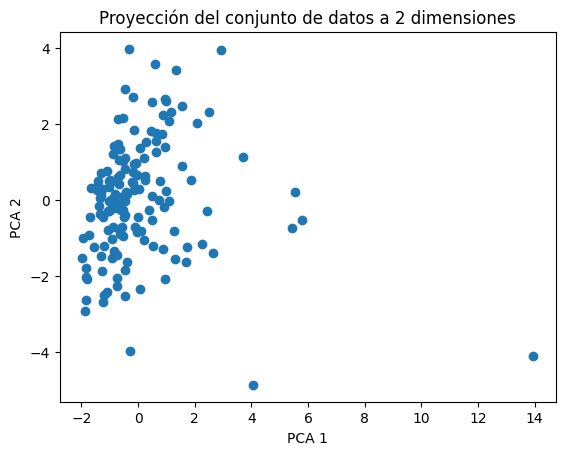

In [73]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = copy_dataset.drop(["sitios","codigo","fecha","campaña","olores","color","espumas","mat_susp","ica","calidad_de_agua"], axis=1)

scaler = StandardScaler()

X_Scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)

principal_Component = pca.fit_transform(X_Scaled)

plt.scatter(principal_Component[:,0], principal_Component[:,1])

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title('Proyección del conjunto de datos a 2 dimensiones')
plt.show()

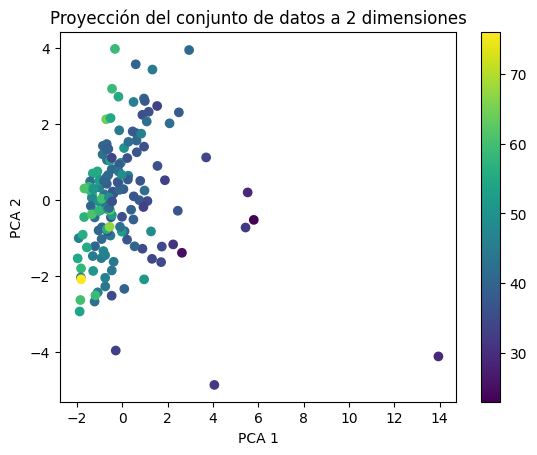

In [75]:
plt.scatter(principal_Component[:,0],principal_Component[:,1],c = copy_dataset["ica"],cmap="viridis")

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title('Proyección del conjunto de datos a 2 dimensiones')
plt.colorbar()
plt.show()

In [76]:
pca.__dict__

{'n_components': 2,
 'copy': True,
 'whiten': False,
 'svd_solver': 'auto',
 'tol': 0.0,
 'iterated_power': 'auto',
 'n_oversamples': 10,
 'power_iteration_normalizer': 'auto',
 'random_state': None,
 'n_features_in_': 19,
 '_fit_svd_solver': 'full',
 'mean_': array([ 1.38417416e-16,  1.84556555e-16, -3.46043540e-17, -2.42230478e-16,
         0.00000000e+00,  4.32554425e-18,  1.44184808e-17, -1.84556555e-16,
         4.61391387e-17,  3.46043540e-17, -3.46043540e-17,  0.00000000e+00,
         1.38417416e-16,  9.22782774e-17,  1.74175249e-15, -4.61391387e-17,
        -7.49761004e-16, -9.22782774e-17,  2.76834832e-16]),
 'noise_variance_': np.float64(0.7997140942446405),
 'n_samples_': 154,
 'n_components_': 2,
 'components_': array([[-0.26075256, -0.1665779 , -0.0883599 ,  0.0937761 ,  0.41430003,
          0.14937901,  0.14461537,  0.1355867 ,  0.4249363 ,  0.09945881,
          0.45405708,  0.42047851,  0.02661541, -0.16724951,  0.10360262,
         -0.03056384, -0.08685673,  0.1815512

In [ ]:
from scipy.stats import shapiro
stats, p = shapiro(copy_dataset["ica"])
print(f"Test de Shapiro-Wilks para ica:Estadistico:{stats:.3f}, p-valor:{p:.3f}")

Test de Shapiro-Wilks para ica:Estadistico:0.959, p-valor:0.000


Pues parece que nuestra variable no se rige por una distribucion normal,vamos a probar el test de Kolmogorov-Smirnov para corroborar

In [ ]:
from scipy.stats import kstest
stats,p = kstest(copy_dataset["ica"],"norm")
print(f"Test de Kolmogorov-Smirnov para ica:Estadistico:{stats:.3f}, p-valor:{p:.3f}")

Test de Kolmogorov-Smirnov para ica:Estadistico:1.000, p-valor:0.000


Ahora verificamos que realmente no sigue una distribucion normal
Entonces vamos a hacer un QQ plot para ver su distribucion

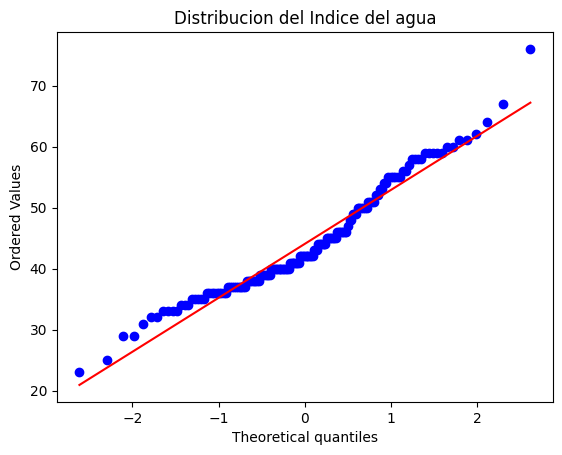

In [ ]:
import scipy.stats as stats

stats.probplot(copy_dataset["ica"],dist="norm",plot=plt)
plt.title("Distribucion del Indice del agua")
plt.show()

Hipotesis: Si el (color,olor,espuma) influencia negativamente al indice de calida de agua 

In [ ]:
from scipy.stats import chi2_contingency

# Crear una tabla de contingencia
contingency_table = pd.crosstab(index=[copy_dataset['olores'], copy_dataset['color'], copy_dataset['espumas']],
                                columns=copy_dataset['ica'])

# Realizar la prueba de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Imprimir resultados
print(f"Estadístico chi-cuadrado: {chi2}")
print(f"Valor p: {p}")
print(f"Grados de libertad: {dof}")


Estadístico chi-cuadrado: 242.9095979740424
Valor p: 0.0027385830261039087
Grados de libertad: 185


Vemos que existe una relacion entre las variables, entonces vamos a ver graficamente que nos dice para entender que tipo de relacion existe

C:\Users\elret\AppData\Local\Temp\ipykernel_13832\349372792.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


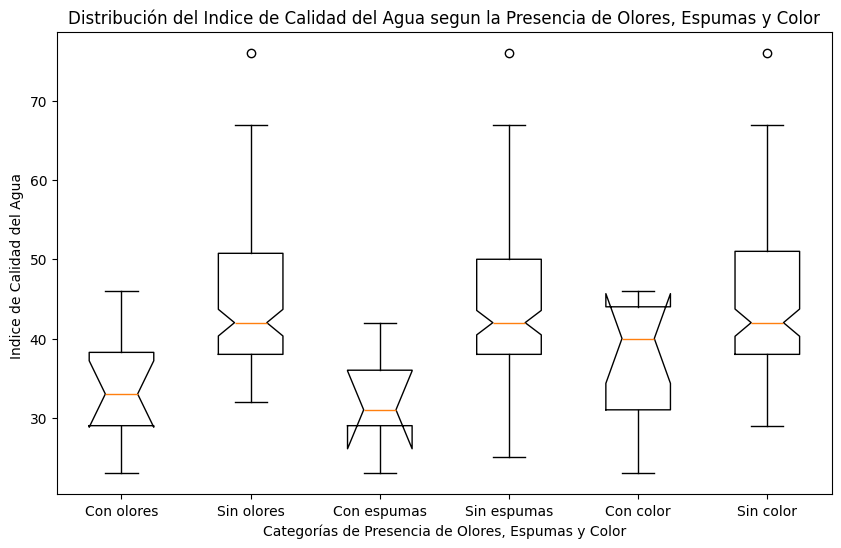

In [176]:
plt.figure(figsize=(10,6))
plt.boxplot([
    copy_dataset[copy_dataset["olores"] == 1.0]["ica"],
    copy_dataset[copy_dataset["olores"] == 0]["ica"],
    copy_dataset[copy_dataset["espumas"] == 1.0]["ica"],
    copy_dataset[copy_dataset["espumas"] == 0]["ica"],
    copy_dataset[copy_dataset["color"] == 1.0]["ica"],
    copy_dataset[copy_dataset["color"] == 0]["ica"]
    ],labels=["Con olores", "Sin olores","Con espumas", "Sin espumas","Con color", "Sin color"],notch=True)

plt.xlabel("Categorías de Presencia de Olores, Espumas y Color")
plt.ylabel("Indice de Calidad del Agua ")
plt.title("Distribución del Indice de Calidad del Agua segun la Presencia de Olores, Espumas y Color")


plt.show()

In [139]:
print(copy_dataset[copy_dataset["color"] == 1.0].shape[0])  # Número de elementos con "color" == 1.0
print(copy_dataset[copy_dataset["color"] == 0.0].shape[0])  # Número de elementos con "color" == 0.0

13
141


In [170]:
# Tomamos una muestra aleatoria de 13 observaciones de color == 0.0
sample_color_0 = copy_dataset[copy_dataset["color"] == 0.0].sample(n=13,random_state=15)

# Asegúrate de que estas muestras estén emparejadas de alguna manera, como por ejemplo usando el índice
# Si no puedes emparejar, la muestra aleatoria puede no ser completamente válida

# Realizamos la prueba de Wilcoxon
estadistico, p_valor = wilcoxon(
    copy_dataset[copy_dataset["color"] == 1.0]["ica"],
    sample_color_0["ica"]
)

print(f"Estadístico: {estadistico}")
print(f"P-valor: {p_valor}")


Estadístico: 21.0
P-valor: 0.09423828125


Hipotesis:

In [ ]:
# Convertir la columna 'fecha' a formato datetime (si no lo está)
copy_dataset['fecha'] = pd.to_datetime(copy_dataset['fecha'])

# Crear una nueva columna 'estacion' para dividir según el mes
copy_dataset['estacion'] = copy_dataset['fecha'].dt.month % 12 // 3 + 1
# El %12 // 3 + 1 asigna estaciones según el mes (1=Primavera, 2=Verano, 3=Otoño, 4=Invierno)

# Establecer el tamaño de la figura
plt.figure(figsize=(12, 8))

# Crear gráficos separados por estación         NO USAR CHATGPT XD
for estacion in copy_dataset['estacion'].unique():
    plt.figure(figsize=(10, 6))
    data_estacion = copy_dataset[copy_dataset['estacion'] == estacion]
    for fecha in data_estacion['fecha'].unique():
        data_fecha = data_estacion[data_estacion['fecha'] == fecha]
        plt.plot(data_fecha['ica'], label=f'Fecha: {fecha}')

    # Configurar gráficos
    plt.xlabel('Índice de Muestra')
    plt.ylabel('ICA')
    plt.grid(True)
    plt.legend(title='Fechas')
    plt.title(f'Valores de ICA en la Estación {estacion}')
    plt.show()  # Mostrar cada gráfico de estación por separado


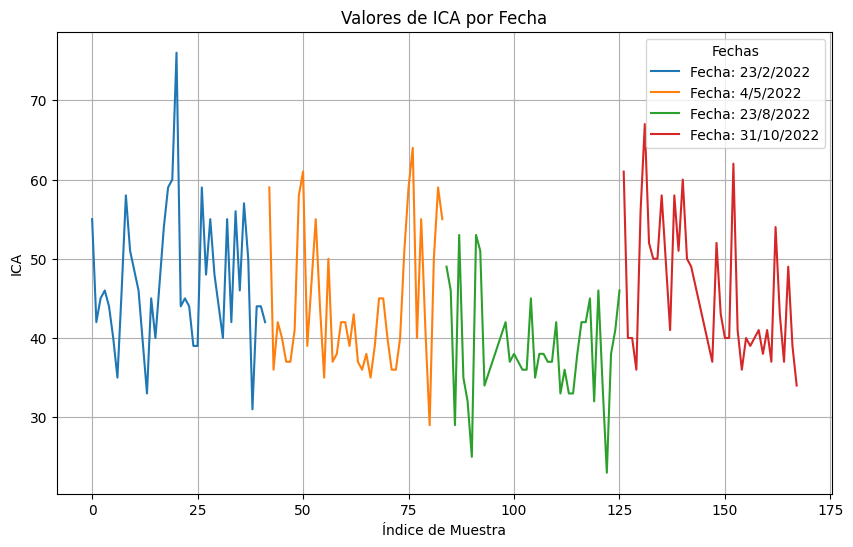

In [ ]:
plt.figure(figsize=(10, 6))
for fecha in copy_dataset['fecha'].unique():
    data_fecha = copy_dataset[copy_dataset['fecha'] == fecha]
    plt.plot(data_fecha['ica'], label=f'Fecha: {fecha}')

plt.xlabel('Índice de Muestra')
plt.ylabel('ICA')
plt.grid(True)
plt.legend(title='Fechas')
plt.title('Valores de ICA por Fecha')
plt.show()

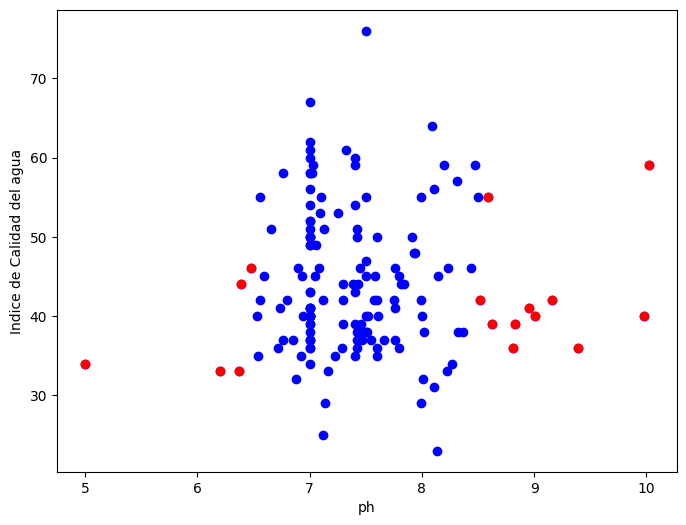

In [ ]:
outliers= copy_dataset[(copy_dataset["ph"] < 6.5)| (copy_dataset["ph"] > 8.5)]
normales= copy_dataset[(copy_dataset["ph"] >= 6.5)| (copy_dataset["ph"] <= 8.5)]

plt.figure(figsize=(8,6))
plt.scatter(normales["ph"], normales["ica"], color="blue")
plt.scatter(outliers["ph"], outliers["ica"], color="red")
plt.xlabel("ph")
plt.ylabel("Indice de Calidad del agua")
plt.title("")
plt.show()

Text(0.5, 1.0, 'Calidad del agua en las 4 estaciones del año')

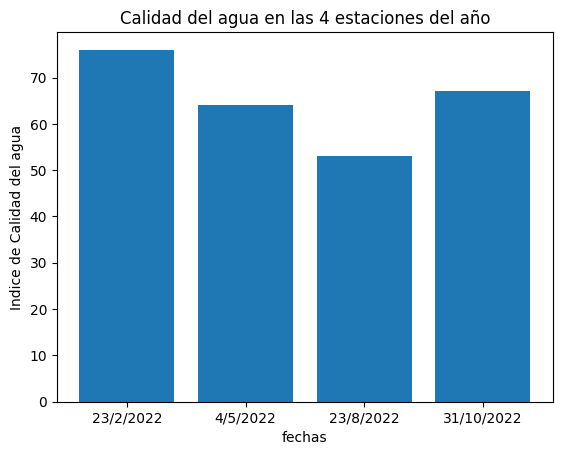

In [ ]:
plt.bar(copy_dataset["fecha"],copy_dataset["ica"])
plt.xlabel("fechas")
plt.ylabel("Indice de Calidad del agua")
plt.title("Calidad del agua en las 4 estaciones del año")

En la imagen se muestra que en el verano es donde hay un indice mayor de calidad de agua y en invierno peor, lo que resulta raro, ya que por logica uno podria intuir que en el verano es donde peor indice tiene.

Vamos a ver unos boxplot para las distintas estaciones y ver que nos dicen

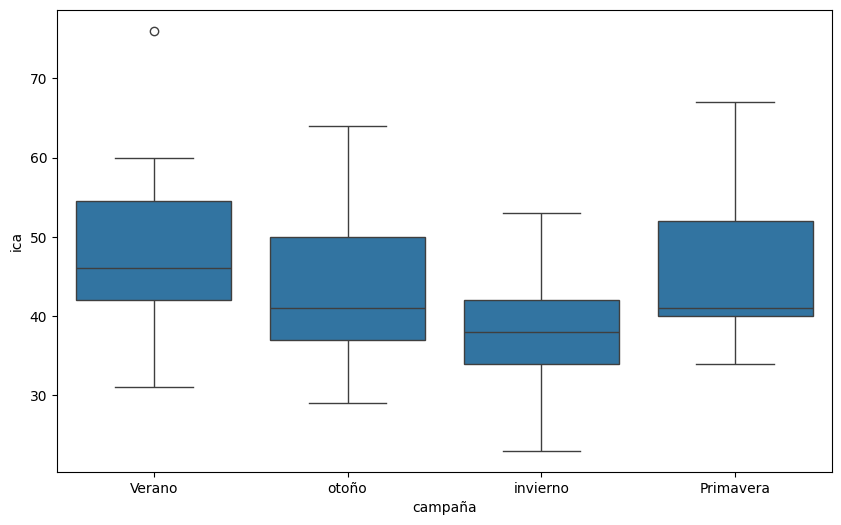

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.boxplot(x=copy_dataset["campaña"],y=copy_dataset["ica"],data=copy_dataset)
plt.xlabel("campaña")
plt.ylabel("ica")
plt.show()

Vemos que en el verano hay un outlier, que luego examinaremos, y en el invierno es donde menos calidad de agua hay.

Ahora veremos la correlacion que tiene esta variable con la turbidez.

In [ ]:
coef = copy_dataset["ica"].corr(copy_dataset["turbiedad_ntu"])
print(f"Coeficiente de correlacion: {coef}")

Coeficiente de correlacion: 0.16051889892460983


Por lo que vemos no existe una correlacion lineal entre las variables, o si existe es muy debil, asi que veamoslo en una grafica.

Veamos que sucede con la correlacion de Spermean

In [ ]:
coef_spearman = copy_dataset['ica'].corr(copy_dataset['turbiedad_ntu'], method='spearman')
print(f'Coeficiente de correlación de Spearman: {coef_spearman}')

Coeficiente de correlación de Spearman: 0.2602812757338662


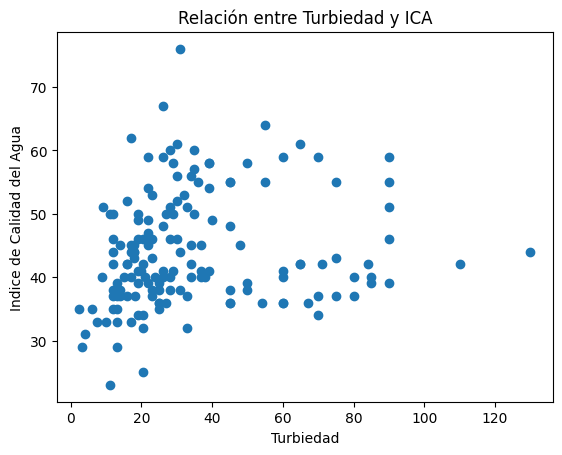

In [ ]:
plt.scatter(copy_dataset["turbiedad_ntu"],copy_dataset["ica"])
plt.xlabel("Turbiedad")
plt.ylabel("Indice de Calidad del Agua")
plt.title("Relación entre Turbiedad y ICA")
plt.show()

Por lo visto no hay una relacion clara, para poder intuir algo.

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
df = copy_dataset.drop(columns=['sitios','codigo','campaña','calidad_de_agua','olores','color','espumas'])
linked = linkage(df,method='single')
plt.figure(figsize=())

ValueError: could not convert string to float: '23/2/2022'

Compilacion de distintas ideas:                                                                                                                       
1_A mayor olor peor color => Analizar relacion entre variables                                                                                        
2_A mayor turbidez menos cristalina es el agua                                                                                                        
3_Analizar el cambio de la calidad del agua en funcion de como pasan las distintas estaciones                                                         
4_Analizar si en de una variable sola afecta en la calidad del agua, en contraste a un conjunto de variables

PERPLEXITY. AI
CONSENSUS.APP
ELECIT.AI